In [2]:
import astropy
import dogpile.cache
import fuzzywuzzy
import os
import re
import marvin
import marvin.utils.plot.map as mapplot
import matplotlib
import numpy as np
import numpyencoder
import packaging
import pandas
import photutils
import raven
import scipy
import sdss_access
import sdsstools
import webargs
import werkzeug
import yamlordereddictloader
import time
import matplotlib.pyplot as plt
import csv



from marvin import config
from marvin.tools import Maps
from marvin.tools.image import Image
from marvin.tools.cube import Cube
from marvin.tools.query import Query
from marvin.utils.datamodel.query.base import query_params
from marvin.tools import RSS
from marvin.utils.general.general import get_drpall_table
from marvin.api.api import Interaction

from astropy.io import fits
from astropy import units as u
from astropy import constants as C

%matplotlib inline
#plt.style.use('seaborn-darkgrid')  # set matplotlib style sheet

config.mode = 'remote'
config.access = 'public'
config.use_sentry = True
config.setRelease('DR17')
config.setDR('DR17')
#config.sasurl
#config.urlmap
config.switchSasUrl(sasmode='mirror', ngrokid=None, port=5000, test=False, base=None, public=True)

In [4]:
#troubleshooting code

'''
print(os.environ['SAS_BASE_DIR'])
print(marvin.config.urlmap)
testcube = Cube(plateifu='8485-1901')
print(testcube)
print(f"RA: {testcube.ra}")
print(f"Dec: {testcube.dec}")

print(testcube.nsa)

# access the spaxel from the lower left corner of the Cube for 8485-1901
spaxel = testcube.getSpaxel(0,0)
# represent the spaxel
print(spaxel)

flux = spaxel.flux
flux.plot()
print(flux.value, flux.ivar, flux.wavelength)

maps = testcube.getMaps()
print(maps)
ha = maps.getMap('emline_gflux_ha_6564')

#maps.datamodel

print(f"Database access: {config.db}")
'''

'\nprint(os.environ[\'SAS_BASE_DIR\'])\nprint(marvin.config.urlmap)\ntestcube = Cube(plateifu=\'8485-1901\')\nprint(testcube)\nprint(f"RA: {testcube.ra}")\nprint(f"Dec: {testcube.dec}")\n\nprint(testcube.nsa)\n\n# access the spaxel from the lower left corner of the Cube for 8485-1901\nspaxel = testcube.getSpaxel(0,0)\n# represent the spaxel\nprint(spaxel)\n\nflux = spaxel.flux\nflux.plot()\nprint(flux.value, flux.ivar, flux.wavelength)\n\nmaps = testcube.getMaps()\nprint(maps)\nha = maps.getMap(\'emline_gflux_ha_6564\')\n\n#maps.datamodel\n\nprint(f"Database access: {config.db}")\n'

In [5]:
# get and format an API url to retrieve basic Cube properties
plateifu = '7443-12701'
url = config.urlmap['api']['getCube']['url']

# create and send the request, and retrieve a response
response = Interaction(url.format(name=plateifu))

# check your response's status code
print(response.status_code, "good if 200")
200

# get the data in your response
data = response.getData()
#print(data)

200 good if 200


In [6]:
images = Image.from_list(['10839-12701', '8330-3701', '9028-12704', '9033-9102'])
for image in images:
    image.show()

[WARNING]: subprocess 1248 is still running (ResourceWarning)
[WARNING]: subprocess 12644 is still running (ResourceWarning)
[WARNING]: subprocess 6168 is still running (ResourceWarning)
[WARNING]: subprocess 13336 is still running (ResourceWarning)


In [7]:
#images2 = marvin.utils.general.images.get_images_by_plate(8485)
#for image in images2:
#    image.show()

**Goal:** redo VCARRS with expanded search using the small angle approx
* use sklearn to train a model on sorting spiral vs elliptical
* repeat rotation curve and CLD measurements to calculate DM content
* create histograms of DM fraction vs # of galaxies, see if there's any differences between spiral and elliptical
* **hypothesis:** elliptical galaxies have higher DM content due to slower rotation and random stellar orbits

8481-6103 0.04674866


[WARNING]: cannot load NSA information for mangaid='51-77'. (MarvinUserWarning)


No cube for 12040-6102
9028-3702 0.04822156


[WARNING]: cannot load NSA information for mangaid='51-70'. (MarvinUserWarning)


No cube for 10148-1901
8249-3703 0.026438024
8137-12705 0.0409416
8991-1901 0.05013228
8322-6104 0.046931956
8091-9101 0.031411078
8247-9101 0.041565735


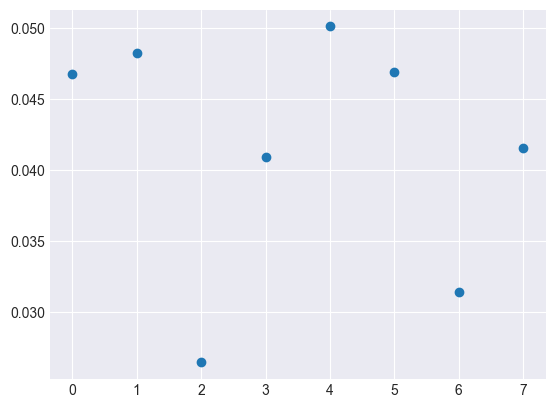

In [8]:
# testing different ways to get NSA parameters, specifically redshift z

images3 = marvin.utils.general.images.get_random_images(10)
test = []

for item in images3:
    #print(item.__dict__)
    ifu = item.plateifu

    try:
        cube = Cube(plateifu = ifu)
        print(ifu, cube.nsa['z'])
        test.append(cube.nsa['z'])

    except:
        print(f"No cube for {ifu}")

xaxis = np.arange(0, len(test), 1)
plt.scatter(xaxis, test)

In [4]:
# the above method is slow and inefficient and sometimes fails completely when it finds a galaxy that lacks NSA params
# Query is much faster:

from marvin.tools.query import Query

my_filter = 'nsa.z < 0.05'
q = Query(search_filter=my_filter)
print(q)

# run the query
r = q.run()

# print some results information
print(r)
print('number of results:', r.totalcount)

Marvin Query(filter='nsa.z < 0.05', mode='remote', data_origin='api')
Marvin Results(query=nsa.z < 0.05, totalcount=7151, count=100, mode=remote)
number of results: 7151


Easy First Step: Rotation Curve
Steps:
1. Import units and constants
2. Seach for galaxies, start with a filter where the inclination angle ~ 0 degrees to our viewing plane
3. Get a stellar velocity dispersion map for every such galaxy
4. Calculate mass from the velocities

* using previous work (STARS final project) as hints

elpetro_ba is the b/a ratio. a high b/a (close to 1) means that the galaxy is close to perfectly face-on, while a low b/a (close to 0) means that the galaxy is perfectly edge-on

In [5]:
my_filter = 'nsa.elpetro_ba > 0.25 and nsa.elpetro_ba < 0.5'
q = Query(search_filter=my_filter)
print(q)

# run the query
r = q.run()

# print some results information
print('number of results:', r.totalcount)

Marvin Query(filter='nsa.elpetro_ba > 0.25 and nsa.elpetro_ba < 0.5', mode='remote', data_origin='api')
number of results: 1597


In [252]:
myfilter = 'nsa.sersic_logmass > 10 and nsa.sersic_logmass < 12 and nsa.elpetro_ba > 0.2 and nsa.elpetro_ba < 0.5'
myparams = ['sersic_n']
q = Query(search_filter = myfilter, return_params = myparams)
results = q.run()
    
# Get the total count of results
total_count = results.totalcount
print(total_count)

601


In [253]:
#query_params.list_params()
query = Query(search_filter = myfilter, return_params = myparams, limit = total_count)
results = query.run()

mangaids = []
sersic_index = []
sersic_logmass = []

for i in range(total_count):
    #print(i, results.results[i])
    mangaids.append(results.results[i][0])
    sersic_index.append(results.results[i][2])
    sersic_logmass.append(results.results[i][4])

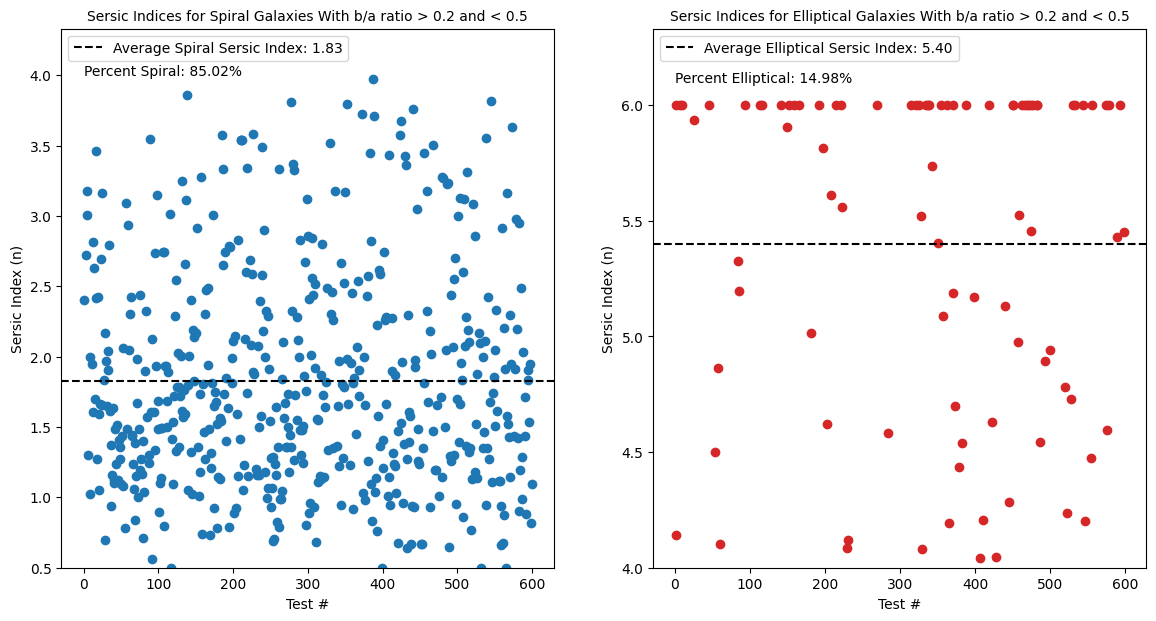

In [288]:
spiral_n = []
elliptical_n = []

fig, ax = plt.subplots(1, 2, figsize = (14, 7))

for index, val in enumerate(sersic_index):
    if val >= 0 and val < 4:
        spiral_n.append(val)
        ax[0].scatter(index, val, color = "tab:blue")
    elif val >= 4:
        elliptical_n.append(val)
        ax[1].scatter(index, val, color = "tab:red")
    else:
        print("???")

average_spiraln = np.sum(spiral_n) / len(spiral_n)
average_ellipticaln = np.sum(elliptical_n) / len(elliptical_n)
#print(average_spiraln, average_ellipticaln)

total = len(spiral_n)+len(elliptical_n)

percent_spiral = (len(spiral_n)/total)*100
percent_elliptical = (len(elliptical_n)/total)*100

ax[0].axhline(y = average_spiraln, label = f'Average Spiral Sersic Index: {average_spiraln:.2f}', linestyle = "--", color = "black")
ax[0].set_xlabel("Test #")
ax[0].set_ylabel("Sersic Index (n)")
ax[0].set_ylim(0.5, 4.33)
ax[0].set_title("Sersic Indices for Spiral Galaxies With b/a ratio > 0.2 and < 0.5", fontsize = 10)
ax[0].text(0, 4, f"Percent Spiral: {percent_spiral:.2f}%", fontsize = 10)
ax[0].legend(fontsize = 10, loc = 'upper left')
ax[1].axhline(y = average_ellipticaln, label = f'Average Elliptical Sersic Index: {average_ellipticaln:.2f}', linestyle = "--", color = "black")
ax[1].set_xlabel("Test #")
ax[1].set_ylabel("Sersic Index (n)")
ax[1].set_ylim(4, 6.33)
ax[1].set_title("Sersic Indices for Elliptical Galaxies With b/a ratio > 0.2 and < 0.5", fontsize = 10)
ax[1].text(0, 6.1, f"Percent Elliptical: {percent_elliptical:.2f}%", fontsize = 10)
ax[1].legend(fontsize = 10, loc = 'upper left')
plt.show()

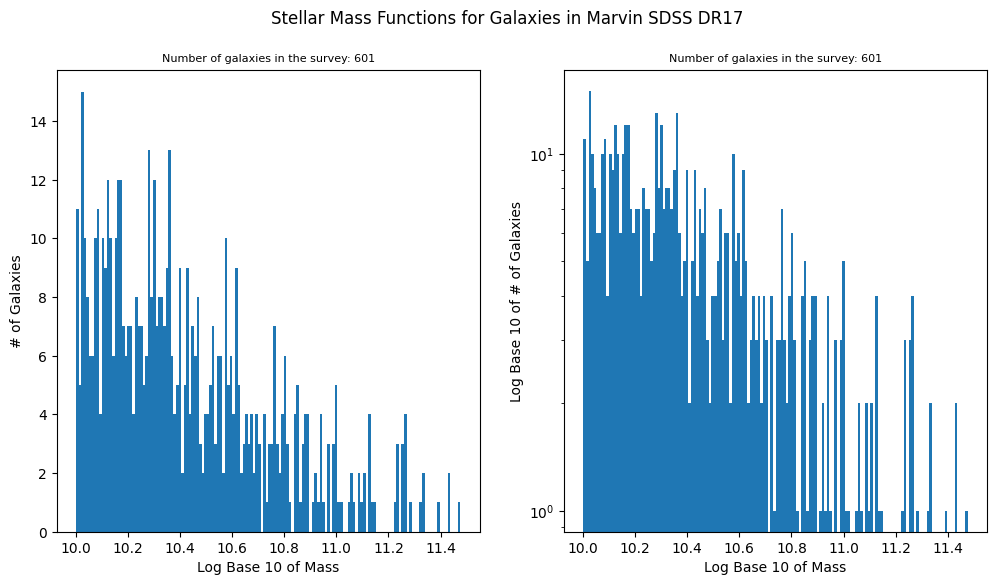

In [289]:
#test = np.arange(1, len(sersic_logmass)+1, 1)

nbins = 150

avg_logmass = (np.sum(sersic_logmass) / len(sersic_logmass))

fig, ax = plt.subplots(1, 2, figsize = (12, 6))
ax[0].hist(sersic_logmass, bins = nbins)
ax[0].set_xlabel("Log Base 10 of Mass")
ax[0].set_ylabel("# of Galaxies")
ax[1].hist(sersic_logmass, bins = nbins)
ax[1].set_xlabel("Log Base 10 of Mass")
ax[1].set_ylabel("Log Base 10 of # of Galaxies")
ax[1].set_yscale("log")
#plt.axvline(x=avg_logmass, color='tab:red', linestyle='--', label= f'Average Sersic Log Mass = {avg_logmass:.2f}')
plt.suptitle("Stellar Mass Functions for Galaxies in Marvin SDSS DR17")
ax[0].set_title(f"Number of galaxies in the survey: {len(sersic_logmass)}", fontsize = 8)
ax[1].set_title(f"Number of galaxies in the survey: {len(sersic_logmass)}", fontsize = 8)
#ax.legend()
plt.show()

In [290]:
# testing how to get maps from a list and how the API works

'''

#testifus = ['8485-1901', '8987-12702']
stellarvel = []
stellarsigmacorr = []
radius = []

for index, mid in enumerate(mangaids[0:10]):
    print(index, mid)
    tries = 0
    while tries < 3:
        
        try:
            maps = Maps(mangaid = mid)
            stellar_velocity = maps.getMap('stellar_vel')            # Stellar velocity is stored in the 'stellar_vel' property.
            stellarvel.append(stellar_velocity)
            stellar_sigma_raw = maps.getMap('stellar_sigma')         # The raw stellar velocity dispersion is in 'stellar_sigma'; must be corrected for instrumental resolution.
            stellar_sigma_corrected = stellar_sigma_raw.inst_sigma_correction()  # Apply the instrumental correction to the velocity dispersion. This will ignore points where the correction is larger than the raw value.
            stellarsigmacorr.append(stellar_sigma_corrected)
            radiusmap = maps.getMap('spx_ellcoo_r_re')
            radius.append(radiusmap)
            break

        except marvin.core.exceptions.MarvinError:
            print("marvin.core.exceptions.MarvinError")
            time.sleep(15)
            tries += 1

        if tries == 3:
            print("Uh oh!")

'''

'\n\n#testifus = [\'8485-1901\', \'8987-12702\']\nstellarvel = []\nstellarsigmacorr = []\nradius = []\n\nfor index, mid in enumerate(mangaids[0:10]):\n    print(index, mid)\n    tries = 0\n    while tries < 3:\n        \n        try:\n            maps = Maps(mangaid = mid)\n            stellar_velocity = maps.getMap(\'stellar_vel\')            # Stellar velocity is stored in the \'stellar_vel\' property.\n            stellarvel.append(stellar_velocity)\n            stellar_sigma_raw = maps.getMap(\'stellar_sigma\')         # The raw stellar velocity dispersion is in \'stellar_sigma\'; must be corrected for instrumental resolution.\n            stellar_sigma_corrected = stellar_sigma_raw.inst_sigma_correction()  # Apply the instrumental correction to the velocity dispersion. This will ignore points where the correction is larger than the raw value.\n            stellarsigmacorr.append(stellar_sigma_corrected)\n            radiusmap = maps.getMap(\'spx_ellcoo_r_re\')\n            radius.

In [12]:
fname = 'C:/Users/steph/sas/dr17/manga/spectro/analysis/v3_1_1/3.1.0/dapall-v3_1_1-3.1.0.fits'
dapall = fits.getdata(fname)

results = {}

filepath = "C:/Users/steph/DMratios.csv"
if os.path.exists(filepath):
    with open(filepath, 'r') as f_in:

        try:
            lines = f_in.readlines()
            for line in lines:
                mid, rot_Mass, lum_Mass, Mratio = line.split(',')
                results[mid] = (rot_Mass, lum_Mass, Mratio)
        except:
            pass

#print(results.keys())

DMratios = []   # probably delete this later because the file itself has the mass ratio information
sersic_index = []

with open(filepath, 'a') as f_out: 
    
    for index, mid in enumerate(mangaids):
        print(index, mid, end = " ")
        
        if mid not in results.keys():
            row = dapall[dapall['MANGAID'] == mid]
            ba = row['NSA_ELPETRO_BA'][0]
            phi = row['NSA_ELPETRO_PHI'][0]
            theta=-(90-phi)
            a = 15     # why 15?
            b = ba*a   # this depends on choice of a
    
            tries = 0
            while tries < 3:
            
                try:
                    # 2 API calls in this block
                    maps = Maps(mangaid = mid, mode = 'remote')
                    cube = Cube(mid)
                    testvmap = maps['stellar_sigma']
                    testrmap = (maps['spx_ellcoo_r_re'].value * dapall[dapall['MANGAID'] == mid]['nsa_elpetro_th50_r'])
                    sersic_index.append(cube.nsa
                    break
    
                except Exception as e:
                    print(e)
                    time.sleep(5)
                    tries += 1
    
            if tries == 3:
                print("Out of tries!")
    
            # 0 API calls in this block
            c = testvmap.shape[0]//2
            aperture = cube.getAperture((c,c),(a,b,np.radians(theta)),aperture_type='elliptical')
            spax = aperture.getSpaxels()
    
            # 0 API calls
            mmap = np.zeros(testvmap.shape)
            for spaxel in spax:
                x = spaxel.x
                y = spaxel.y
                v = testvmap[y,x]   # spaxels returned as (y,x) ordered pairs
                r = testrmap[y,x]
        
                m = ((v.value**2)*((r*u.kpc).to(u.km).value)/(C.G.to(u.km**3 / u.M_sun / u.s**2).value))
                #print(v, r, m)
                mmap[y,x] = m
    
            # 0 API calls
            rot_Mass = mmap.max()
            lum_Mass = 10 ** Maps(mid).nsa['sersic_logmass']
            Mratio = rot_Mass / lum_Mass
            print(rot_Mass, lum_Mass, Mratio)
            DMratios.append(Mratio)
            results[mid] = (rot_Mass, lum_Mass, Mratio)
            
            f_out.write(f"{mid},{rot_Mass},{lum_Mass},{Mratio}\n")
    
        else:
            print("Galaxy already processed")

# total API calls = 2 per loop


#plt.imshow(mmap,origin='lower', cmap = 'viridis')
#plt.colorbar(label='Mass (in Solar Masses)', orientation = 'vertical')
#plt.title('Cumulative Mass Map')
#plt.xlabel('Spaxels')
#plt.ylabel('Spaxels')

0 1-10177 Galaxy already processed
1 1-10425 Galaxy already processed
2 1-106664 Galaxy already processed
3 1-107841 Galaxy already processed
4 1-108250 Galaxy already processed
5 1-109244 Galaxy already processed
6 1-109394 Galaxy already processed
7 1-109909 Galaxy already processed
8 1-113418 Galaxy already processed
9 1-114325 Galaxy already processed
10 1-114973 Galaxy already processed
11 1-115128 Galaxy already processed
12 1-115162 Galaxy already processed
13 1-115317 Galaxy already processed
14 1-115345 Galaxy already processed
15 1-115365 Galaxy already processed
16 1-115380 Galaxy already processed
17 1-115427 Galaxy already processed
18 1-115435 Galaxy already processed
19 1-116087 Galaxy already processed
20 1-117014 Galaxy already processed
21 1-117088 Galaxy already processed
22 1-117635 Galaxy already processed
23 1-117981 Galaxy already processed
24 1-118221 Galaxy already processed
25 1-118970 Galaxy already processed
26 1-119740 Galaxy already processed
27 1-120803 G

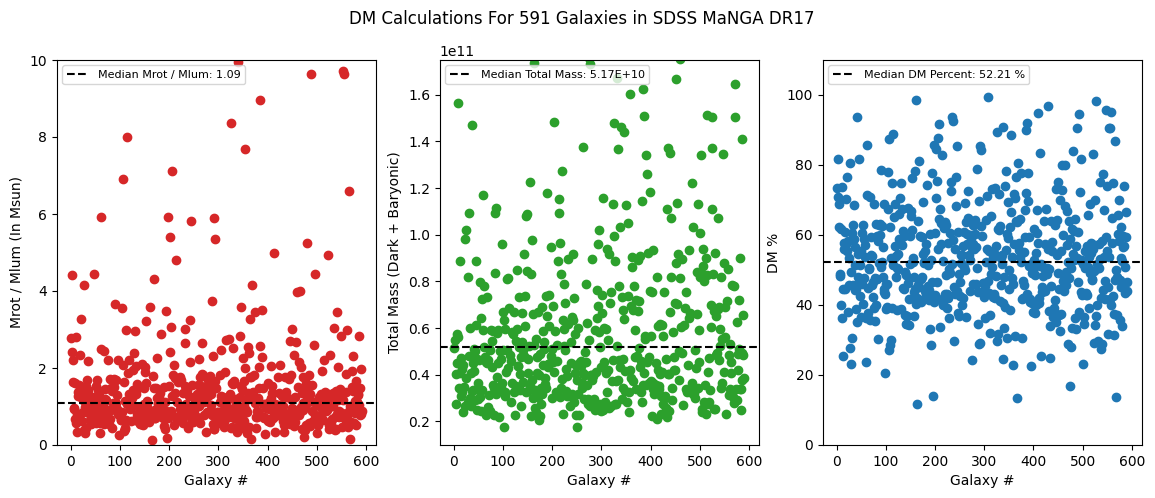

In [214]:
filepath = "C:/Users/steph/DMratios.csv"
nbins = 100

testedids = []
testedrotmasses = []
testedbarymasses = []
massratios = []

with open(filepath, 'r', newline='') as csvfile:
    csv_reader = csv.reader(csvfile)
    for row in csv_reader:
        testedids.append(row[0])
        testedrotmasses.append(float(row[1]))
        testedbarymasses.append(float(row[2]))
        massratios.append(float(row[3]))

test = np.arange(1, len(massratios)+1, 1)
median_DM_ratio = np.median(massratios)
total_mass = np.array(testedrotmasses) + np.array(testedbarymasses)
median_total_mass = np.median(total_mass)
DM_percent = 100 * (np.array(testedrotmasses) / total_mass)
median_DM_percent = np.median(DM_percent)

fig, axs = plt.subplots(1, 3, figsize = (14, 5))

axs[0].scatter(test, massratios, color = "tab:red")
axs[0].set_xlabel("Galaxy #")
axs[0].set_ylabel("Mrot / Mlum (In Msun)")
axs[0].set_ylim(0, 10)
axs[0].axhline(y = median_DM_ratio, label = f"Median Mrot / Mlum: {median_DM_ratio:.2f}", linestyle = "--", color = "black")
axs[0].legend(loc = 'upper left', fontsize = 8)

axs[1].scatter(test, total_mass, color = "tab:green")
axs[1].set_xlabel("Galaxy #")
axs[1].set_ylabel("Total Mass (Dark + Baryonic)")
axs[1].set_ylim(1e10, 1.75e11)
axs[1].axhline(y = median_total_mass, label = f"Median Total Mass: {median_total_mass:.2E}", linestyle = "--", color = "black")
axs[1].legend(loc = 'upper left', fontsize = 8)

axs[2].scatter(test, DM_percent, color = "tab:blue")
axs[2].set_xlabel("Galaxy #")
axs[2].set_ylabel("DM %")
axs[2].set_ylim(0, 110)
axs[2].axhline(y = median_DM_percent, label = f"Median DM Percent: {median_DM_percent:.2f} %", linestyle = "--", color = "black")
axs[2].legend(loc = 'upper left', fontsize = 8)

plt.suptitle(f"DM Calculations For {len(testedids)} Galaxies in SDSS MaNGA DR17")
plt.show()